# Tutorial 5: Ac225 Kernel Fitting

This tutorial demonstrates how to fit the PSF model from THIS PAPER to acquired Ac225 Monte Carlo point source data from the SIMIND Monte Carlo program. The data used also corresponds to that paper.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from spectpsftoolbox.simind_io import get_projections, get_source_detector_distances
from spectpsftoolbox.kernel1d import ArbitraryKernel1D, FunctionKernel1D
from spectpsftoolbox.operator2d import GaussianOperator, Rotate1DConvOperator, RotateSeperable2DConvOperator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

First we'll specify all the `header` paths and `.res` for the SIMIND PSF simulation data

In [6]:
E = 440
ds = [1,5,10,15,20,25,30,35,40,45,50,55]
headerpaths = [f'/home/gpuvmadm/spect_psf_fitting/datalarger/{E}kev_r{d}_tot_w1.h00' for d in ds]
respaths = [f'/home/gpuvmadm/spect_psf_fitting/datalarger/{E}kev_r{d}.res' for d in ds]

Now we can open the projections data. We simulated a 255x255 grid with 0.24cm spacing:

In [8]:
Nx0 = 255
dx0 = 0.24
x_eval = y_eval = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
projectionss_data = get_projections(headerpaths).to(device)[:,1:,1:]

# Get distances from scanner for each PSF
distances = get_source_detector_distances(respaths).to(device)
a_min = torch.min(distances).item()
a_max = torch.max(distances).item()

Plot some of the PSF data at different distances:

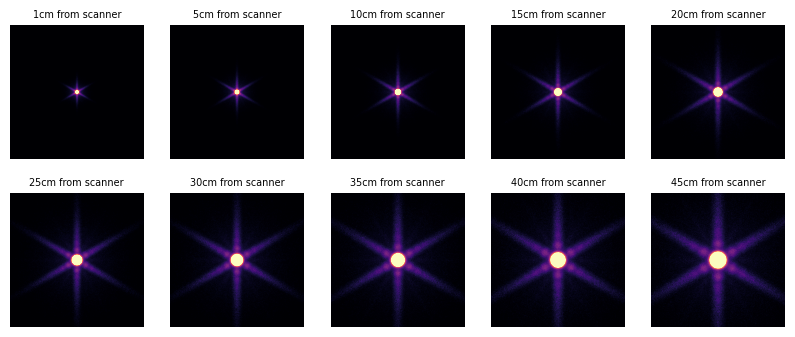

In [9]:
fig, ax = plt.subplots(2,5,figsize=(10,4))
for i in range(10):
    plt.sca(ax.ravel()[i])
    plt.imshow(projectionss_data[i].cpu().numpy(), cmap='magma', vmax=projectionss_data[i].cpu().numpy().max()/10)
    plt.title(f'{distances[i].item():.0f}cm from scanner', fontsize=7)
    plt.axis('off')

Now we'll start building the components to model this PSF. Our model will consist of (i) a Gaussian component, (ii) a rotate 1D kernel and (iii) an exponential background component consisting of two 1D kernels. Our full PSF can be written as

$$PSF(x,y,d) = G(x,y;d,b_G) + RK(x,y;d,b_{RK}) + EXP(x,y;d,b_{EXP})$$

Note that each of the 2D PSFs depends on the distance away from the camera, and some hyperparameters $b$. 

## Gaussian Component

Our Gaussian component will be modeled as

$$G(x,y;d,b) = A(d,b)e^{-(x^2+y^2)/2\sigma(d,b)^2} $$
* $A(d,b) = b_0 e^{-b_1 d} + b_2e^{-b_3 d}$
* $\sigma(d,b) = b_0 +b_1(\sqrt{d^2+b_2^2} - |b_2|)$

Note that each of the $b$  are seperate ($b_0$ for $A$ is different from the $b_0$ for $\sigma$), so there are 7 total hyperparameters for this model. We start by defining the amplitude/scaling functions and their initial parameters

In [10]:
gauss_amplitude_fn = lambda a, bs: bs[0]*torch.exp(-a*bs[1]) + bs[2]*torch.exp(-a*bs[3])
gauss_sigma_fn = lambda a, bs: bs[0] + bs[1]*(torch.sqrt(a**2 + bs[2]**2) - torch.abs(bs[2]))
gauss_amplitude_params = torch.tensor([10,0.05,5,0.041], requires_grad=True, device=device)
gauss_sigma_params = torch.tensor([1.,0.03,0.01], requires_grad=True, device=device)

These are simply functions of distance with hyperparameters which we can plot:

Text(0, 0.5, '$A(d;b)$')

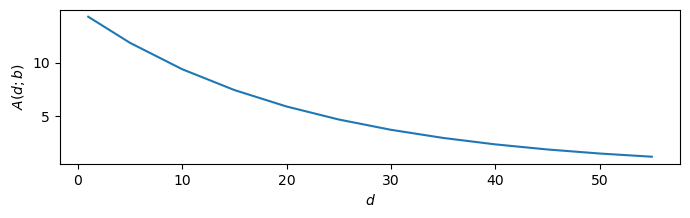

In [11]:
plt.figure(figsize=(8,2))
plt.plot(distances.cpu().numpy(), gauss_amplitude_fn(distances, gauss_amplitude_params).cpu().detach().numpy())
plt.xlabel('$d$')
plt.ylabel('$A(d;b)$')

Now we create the operator from these amplitude and sigma parameters:

In [12]:
gaussian_operator = GaussianOperator(
    gauss_amplitude_fn,
    gauss_sigma_fn,
    gauss_amplitude_params,
    gauss_sigma_params,
)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


This operator takes in an input tensor of shape [L_d, L_x, L_y], an x meshgrid, a y meshgrid, and array of distances, and applies the PSF to the input tensor

In [13]:
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
distances = torch.tensor([1,6,10,20,45]).to(device)
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,127,127] = 1 # line along center
gaussian_psf = gaussian_operator(input, xv, yv, distances)
print(gaussian_psf.shape)

torch.Size([5, 255, 255])


We can view at the different distances

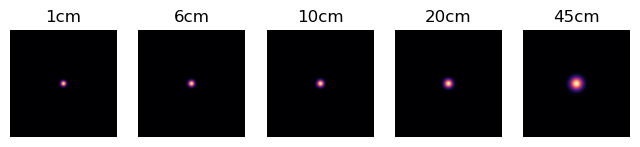

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(8,2))
for i in range(5):
    ax[i].set_title(f'{distances[i].item():.0f}cm')
    ax[i].imshow(gaussian_psf[i].cpu().detach().numpy(), cmap='magma')
    ax[i].axis('off')

This will be optimized during fitting

## Tail Component

The tail component has the form 

$$RK(x,y;d,b_{RK}) = \sum_{\theta_i}R(-\theta_i)K(x;d,b)R(\theta_i)$$

The kernel has the following form

$$K(x;d,b) = A(d,b)K(x/\sigma(d,b))$$
* $A(d,b) = b_0e^{-b_1 d} + b_2e^{-b_3 d}$
* $\sigma(d,b) = 1+b_0(\sqrt{(a-a_{\text{min}})^2+b_1^2} - |b_1|)$

All the parameters of the kernel $K$ are left arbitrary, it is of length 255 and will be initialized as $e^{-0.1x}$. All 255 values are independent parameters.

There are three rotation angles: 0, 120, 240, which gives the hexagonal shape

In [15]:
# Tail Component
Nx_tail = round(np.sqrt(2)*Nx0)
if Nx_tail%2==0:
    Nx_tail += 1
x = torch.arange(-(Nx_tail-1)/2, (Nx_tail+1)/2, 1).to(device) * dx0
tail_kernel = torch.tensor(torch.exp(-0.1*torch.abs(x)), requires_grad=True, device=device)
tail_amplitude_fn = lambda a, bs: bs[0]*torch.exp(-a*bs[1]) + bs[2]*torch.exp(-a*bs[3])
tail_sigma_fn = lambda a, bs, a_min=a_min: 1 + bs[0]*(torch.sqrt((a-a_min)**2 + bs[1]**2) - torch.abs(bs[1]))
tail_amplitude_params = torch.tensor([0.01,0.01,0.011,0.011], requires_grad=True, device=device)
tail_sigma_params = torch.tensor([0.1,0.1], requires_grad=True, device=device)
tail_kernel1D = ArbitraryKernel1D(tail_kernel, tail_amplitude_fn, tail_sigma_fn, tail_amplitude_params, tail_sigma_params, dx0, grid_sample_mode='bicubic')
tail_operator = Rotate1DConvOperator(
    tail_kernel1D,
    N_angles = 3,
    additive=True,
    rot=90,
)

/tmp/ipykernel_18977/4173190168.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tail_kernel = torch.tensor(torch.exp(-0.1*torch.abs(x)), requires_grad=True, device=device)


We can chain together the operators and look at the resulting PSF:

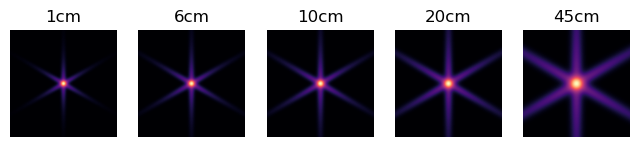

In [16]:
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
distances = torch.tensor([1,6,10,20,45]).to(device)
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,127,127] = 1 # line along center
chained_psf = tail_operator*gaussian_operator
psf = chained_psf(input, xv, yv, distances)
fig, ax = plt.subplots(1, 5, figsize=(8,2))
for i in range(5):
    ax[i].set_title(f'{distances[i].item():.0f}cm')
    ax[i].imshow(psf[i].cpu().detach().numpy(), cmap='magma')
    ax[i].axis('off')

# Homogeneous Background Component

The background component has the form 

$$EXP(x,y;d,b_{RK}) = K_{EXP}(x;d,b)K_{EXP}(y;d,b)$$

The kernel has the following form

$$K_{EXP}(x;d,b) = A(d,b)K(x/\sigma(d,b))$$
* $A(d,b) = b_0e^{-b_1 d} + b_2e^{-b_3 d}$
* $\sigma(d,b) = 1+b_0(\sqrt{(a-a_{\text{min}})^2+b_1^2} - |b_1|)$
* $K(x) = e^{-|x|}$

We can build it as follows:

In [17]:
bkg_amplitude_fn = lambda a, bs: bs[0]*torch.exp(-a*bs[1]) + bs[2]*torch.exp(-a*bs[3])
bkg_sigma_fn = lambda a, bs: bs[0] + bs[1]*(torch.sqrt(a**2 + bs[2]**2) - torch.abs(bs[2]))
bkg_mu_fn = lambda a, bs: 0
bkg_amplitude_params = torch.tensor([0.15,0.1,0.1,0.11], requires_grad=True, device=device)
bkg_sigma_params = torch.tensor([4.,0.1, 0.1], requires_grad=True, device=device)
bkg_mu_params = None
kernel_fn = lambda x: torch.exp(-torch.abs(x))
bkg_kernel1D = FunctionKernel1D(kernel_fn, bkg_amplitude_fn, bkg_sigma_fn, bkg_amplitude_params, bkg_sigma_params, a_min=a_min, a_max=a_max)
bkg_operator = RotateSeperable2DConvOperator(
    bkg_kernel1D,
    N_angles = 1,
    additive=False
)

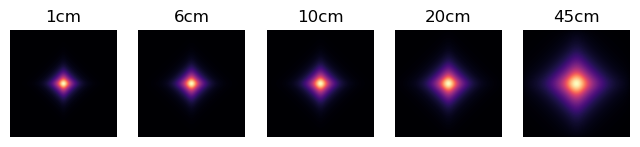

In [18]:
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
distances = torch.tensor([1,6,10,20,45]).to(device)
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,127,127] = 1 # line along center
chained_psf = bkg_operator*gaussian_operator
psf = chained_psf(input, xv, yv, distances, normalize=True)
fig, ax = plt.subplots(1, 5, figsize=(8,2))
for i in range(5):
    ax[i].set_title(f'{distances[i].item():.0f}cm')
    ax[i].imshow(psf[i].cpu().detach().numpy().T, cmap='magma')
    ax[i].axis('off')

## Full Operator

In [19]:
psf_operator = (tail_operator + bkg_operator) * gaussian_operator + gaussian_operator

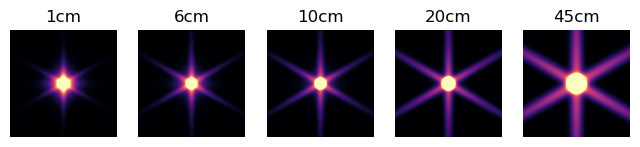

In [20]:
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
distances = torch.tensor([1,6,10,20,45]).to(device)
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,127,127] = 1 # line along center
psf = psf_operator(input, xv, yv, distances)
fig, ax = plt.subplots(1, 5, figsize=(8,2))
for i in range(5):
    ax[i].set_title(f'{distances[i].item():.0f}cm')
    ax[i].imshow(psf[i].cpu().detach().numpy(), cmap='magma', vmax=psf[i].cpu().detach().numpy().max()/10)
    ax[i].axis('off')

# Optimization

In [22]:
distances = get_source_detector_distances(respaths).to(device)
Nx0 = 255
dx0 = 0.24
x_eval = y_eval = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,127,127] = 1 # line along center

The following are torch loss/training loops which we can use to optimize all the parameters.

In [23]:
def loss_fn(psf_pred, psf_data):
    return torch.sum((psf_pred - psf_data)**2)  

def train_w(operator, n_iters, lr=1e-3):
    optimizer = optim.Adam([*operator.params], lr=lr)
    for _ in range(n_iters):
        optimizer.zero_grad()
        error = loss_fn(operator(input,xv,yv,distances),projectionss_data)
        print(error.item(), end="\r")
        error.backward()
        optimizer.step()

We'll train the Gaussian first:

In [24]:
train_w(gaussian_operator, n_iters=10000, lr=1e-2)

Then the full:

In [25]:
train_w(psf_operator, n_iters=15000, lr=1e-3)

/data/anaconda/envs/pytomo_install_test/lib/python3.11/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


Lets compare the fit to the true PSF:

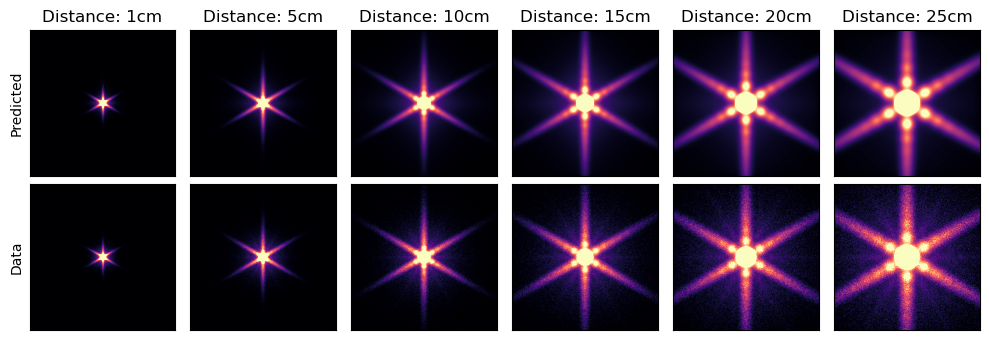

In [26]:
psf_pred = psf_operator(input, xv,yv,distances)

fig, ax = plt.subplots(2, 6, figsize=(10,3.5))
for i in range(6):
    vmax = psf_pred[2*i].cpu().detach().numpy().max()/30
    plt.sca(ax[0,i])
    plt.imshow(psf_pred[2*i].cpu().detach().numpy(), cmap='magma', vmax=vmax)
    plt.sca(ax[1,i])
    plt.imshow(projectionss_data[2*i].cpu().numpy(), cmap='magma', vmax=vmax)
    ax[0,i].set_title('Distance: {:.0f}cm'.format(distances[i].item()))

[a.set_xticks([]) for a in ax.ravel()]
[a.set_yticks([]) for a in ax.ravel()]
ax[0,0].set_ylabel('Predicted')
ax[1,0].set_ylabel('Data')
fig.tight_layout()

In [27]:
psf_operator(input, xv,yv,distances, normalize=True).sum(dim=(1,2))

tensor([0.9894, 1.0001, 0.9998, 0.9983, 0.9946, 0.9889, 0.9814, 0.9732, 0.9637,
        0.9551, 0.9478, 0.9409], device='cuda:0', grad_fn=<SumBackward1>)

And at a lower resolution:

In [28]:
psf_operator.set_device('cuda')

In [30]:
distances = get_source_detector_distances(respaths).to(device)
Nx0 = 127
dx0 = 0.48
x_eval = y_eval = torch.arange(-(Nx0-1)/2, (Nx0+1)/2, 1).to(device) * dx0
xv, yv = torch.meshgrid(x_eval, y_eval, indexing='xy')
input = torch.zeros(len(distances), Nx0, Nx0, device=device)
input[:,63,63] = 1. # line along center
psf_pred = psf_operator(input, xv,yv,distances, normalize=True)

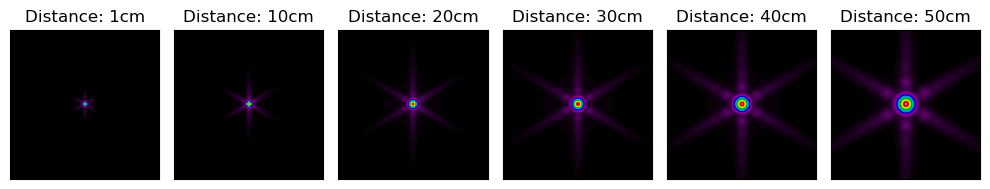

In [31]:
fig, ax = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    vmax = psf_pred[2*i].cpu().detach().numpy().max()
    plt.sca(ax[i])
    plt.imshow(psf_pred[2*i].cpu().detach().numpy(), cmap='nipy_spectral')
    ax[i].set_title('Distance: {:.0f}cm'.format(distances[2*i].item()))
[a.set_xticks([]) for a in ax.ravel()]
[a.set_yticks([]) for a in ax.ravel()]
fig.tight_layout()

In [32]:
psf_operator(input, xv,yv,distances, normalize=True).sum(dim=(1,2))

tensor([1.0008, 1.0041, 1.0011, 0.9986, 0.9946, 0.9887, 0.9810, 0.9726, 0.9629,
        0.9541, 0.9466, 0.9397], device='cuda:0', grad_fn=<SumBackward1>)

We can save it to use in PyTomography as follows:

In [33]:
psf_operator.save(f'/home/gpuvmadm/PointSpreadFunctionFitter/notebook_testing/psf_operator_ac225.pkl')